# Mushroom Lightning ResNet

timm (PyTorch Image Models) provides models based on torch.nn.Module, which allows for smooth integration with the PyTorch ecosystem and frameworks (e.g. PyTorch Lightning).

In [1]:
!pip install lightning 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.1/821.1 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 5.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-1

In [2]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, SubsetRandomSampler
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

#the latest environement
from lightning.pytorch import LightningModule
from lightning.pytorch import LightningDataModule
from lightning.pytorch import Trainer
import lightning.pytorch as L
print(L.__version__)

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models

2.5.2


2025-06-28 22:55:40.821981: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751151341.255636      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751151341.370170      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
dir0='/kaggle/input/mushroom1/merged_dataset'

In [4]:
classes=[]
paths=[]
for dirname, _, filenames in os.walk(dir0):
    for filename in filenames:
        classes+=[dirname.split('/')[-1]]
        paths+=[(os.path.join(dirname, filename))]    

In [5]:
dataset0=datasets.ImageFolder(root=dir0)
class_names=dataset0.classes
print(class_names)
print(len(class_names))

['Agaricus augustus', 'Agaricus xanthodermus', 'Amanita amerirubescens', 'Amanita augusta', 'Amanita brunnescens', 'Amanita calyptroderma', 'Amanita citrina', 'Amanita flavoconia', 'Amanita muscaria', 'Amanita pantherina', 'Amanita persicina', 'Amanita phalloides', 'Amanita rubescens', 'Amanita velosa', 'Apioperdon pyriforme', 'Armillaria borealis', 'Armillaria mellea', 'Armillaria tabescens', 'Artomyces pyxidatus', 'Bjerkandera adusta', 'Bolbitius titubans', 'Boletus edulis', 'Boletus pallidus', 'Boletus reticulatus', 'Boletus rex-veris', 'Calocera viscosa', 'Calycina citrina', 'Cantharellus californicus', 'Cantharellus cibarius', 'Cantharellus cinnabarinus', 'Cerioporus squamosus', 'Cetraria islandica', 'Chlorociboria aeruginascens', 'Chlorophyllum brunneum', 'Chlorophyllum molybdites', 'Chondrostereum purpureum', 'Cladonia fimbriata', 'Cladonia rangiferina', 'Cladonia stellaris', 'Clitocybe nebularis', 'Clitocybe nuda', 'Coltricia perennis', 'Coprinellus disseminatus', 'Coprinellus 

In [6]:
N=list(range(len(classes)))
normal_mapping=dict(zip(class_names,N)) 
reverse_mapping=dict(zip(N,class_names))            

data=pd.DataFrame(columns=['path','class','label'])
data['path']=paths
data['class']=classes
data['label']=data['class'].map(normal_mapping)
print(len(data))

104088


In [7]:
transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [8]:
def create_path_label_list(df):
    path_label_list = []
    for _, row in df.iterrows():
        path = row['path']
        label = row['label']
        path_label_list.append((path, label))
    return path_label_list

path_label = create_path_label_list(data)
path_label = random.sample(path_label,20000)
print(len(path_label))
print(path_label[0:3])

20000
[('/kaggle/input/mushroom1/merged_dataset/Merulius tremellosus/18546medium.jpg', 101), ('/kaggle/input/mushroom1/merged_dataset/Parmelia sulcata/35552medium.jpeg', 110), ('/kaggle/input/mushroom1/merged_dataset/Fomes fomentarius/13961medium.jpeg', 55)]


In [9]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, path_label, transform=None):
        self.path_label = path_label
        self.transform = transform

    def __len__(self):
        return len(self.path_label)

    def __getitem__(self, idx):
        path, label = self.path_label[idx]
        img = Image.open(path).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        return img, label

In [10]:
class DataModule(LightningDataModule):

    def __init__(self, 
                 data_source=None, 
                 path_label=None, 
                 root_dir=None,
                 batch_size=32, 
                 train_split=0.8,
                 custom_transform=None):

        super().__init__()
        
        # Auto-detect data source if not specified
        if data_source is None:
            if path_label is not None:
                data_source = 'custom'
            elif root_dir is not None:
                data_source = 'imagefolder'
        
        self.data_source = data_source
        self.path_label = path_label
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.train_split = train_split
        
        # Set up transforms
        if custom_transform is not None:
            self.transform = custom_transform
        else:
            self.transform = transforms.Compose([
                transforms.Resize(224),             # resize shortest side to 224 pixels
                transforms.CenterCrop(224),         # crop longest side to 224 pixels at center            
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406],
                                   [0.229, 0.224, 0.225])
            ])
        
        # Initialize dataset containers
        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None
    
    def setup(self, stage=None):
        """Setup datasets based on the data source type."""
        
        if self.data_source == 'custom' and self.path_label is not None:
            # Use custom dataset approach
            dataset = CustomDataset(self.path_label, self.transform)
            dataset_size = len(dataset)
            train_size = int(self.train_split * dataset_size) 
            val_size = dataset_size - train_size
            
            print(f"Custom dataset - Train size: {train_size}, Val size: {val_size}")
            
            self.train_dataset = torch.utils.data.Subset(dataset, range(train_size))
            self.val_dataset = torch.utils.data.Subset(dataset, range(train_size, dataset_size))
            
        elif self.data_source == 'imagefolder' and self.root_dir is not None:
            # Use ImageFolder approach
            dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
            n_data = len(dataset)
            n_train = int(self.train_split * n_data)
            n_val = n_data - n_train
            
            print(f"ImageFolder dataset - Train size: {n_train}, Val size: {n_val}")
            
            train_dataset, val_dataset = torch.utils.data.random_split(
                dataset, [n_train, n_val]
            )
            self.train_dataset = train_dataset
            self.val_dataset = val_dataset
            
        else:
            raise ValueError(
                "Must specify either 'custom' data_source with path_label or "
                "'imagefolder' data_source with root_dir"
            )
    
    def train_dataloader(self):
        """Return training data loader."""
        if self.train_dataset is None:
            raise RuntimeError("Training dataset not initialized. Call setup() first.")
        return DataLoader(
            self.train_dataset, 
            batch_size=self.batch_size, 
            shuffle=True,
            num_workers=4,
            pin_memory=True
        )
    
    def val_dataloader(self):
        """Return validation data loader."""
        if self.val_dataset is None:
            raise RuntimeError("Validation dataset not initialized. Call setup() first.")
        return DataLoader(
            self.val_dataset, 
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=4,
            pin_memory=True
        )
    
    def test_dataloader(self):
        """Return test data loader (alias for val_dataloader for compatibility)."""
        return self.val_dataloader()
    
    def __len__(self):
        """Return total dataset size."""
        total_size = 0
        if self.train_dataset is not None:
            total_size += len(self.train_dataset)
        if self.val_dataset is not None:
            total_size += len(self.val_dataset)
        return total_size
    
    def get_num_classes(self):
        """Get number of classes in the dataset."""
        if self.data_source == 'imagefolder' and self.root_dir is not None:
            temp_dataset = datasets.ImageFolder(root=self.root_dir)
            return len(temp_dataset.classes)
        elif self.data_source == 'custom' and self.path_label is not None:
            # Assuming CustomDataset has a way to get number of classes
            temp_dataset = CustomDataset(self.path_label, None)
            if hasattr(temp_dataset, 'num_classes'):
                return temp_dataset.num_classes
            else:
                # If CustomDataset doesn't have num_classes, you'll need to implement this
                print("Warning: Cannot determine number of classes for custom dataset")
                return None
        return None

In [11]:
import timm

class ConvolutionalNetwork(LightningModule):

    def __init__(self, num_classes):
        super().__init__()
        self.base_model = timm.create_model('resnet152', 
                                            pretrained=True, 
                                            num_classes=len(class_names))

    def forward(self, x):
        return self.base_model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("val_loss", loss)
        self.log("val_acc", acc)

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("test_loss", loss)
        self.log("test_acc", acc)

In [12]:
if __name__ == '__main__':
    datamodule = DataModule(path_label=path_label)
    datamodule.setup()
    
    model = ConvolutionalNetwork(num_classes=len(class_names))

    trainer = L.Trainer(
        max_epochs=4, 
        accelerator="cpu", 
        devices=1) 
    
    trainer.fit(model, datamodule)
    datamodule.setup(stage='test')
    test_loader = datamodule.test_dataloader()
    trainer.test(dataloaders=test_loader)

Custom dataset - Train size: 16000, Val size: 4000


model.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO: 
  | Name       | Type   | Params | Mode 
----------------------------------------------
0 | base_model | ResNet | 58.5 M | train
----------------------------------------------
58.5 M    Trainable params
0         Non-trainable params
58.5 M    Total params
233.960   Total estimated model params size (MB)
625       Modules in train mode
0         Modules in eval mode


Custom dataset - Train size: 16000, Val size: 4000


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=4` reached.


Custom dataset - Train size: 16000, Val size: 4000


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
INFO: Restoring states from the checkpoint path at /kaggle/working/lightning_logs/version_0/checkpoints/epoch=3-step=2000.ckpt


Custom dataset - Train size: 16000, Val size: 4000


INFO: Loaded model weights from the checkpoint at /kaggle/working/lightning_logs/version_0/checkpoints/epoch=3-step=2000.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6625000238418579     │
│         test_loss         │    1.2731441259384155     │
└───────────────────────────┴───────────────────────────┘

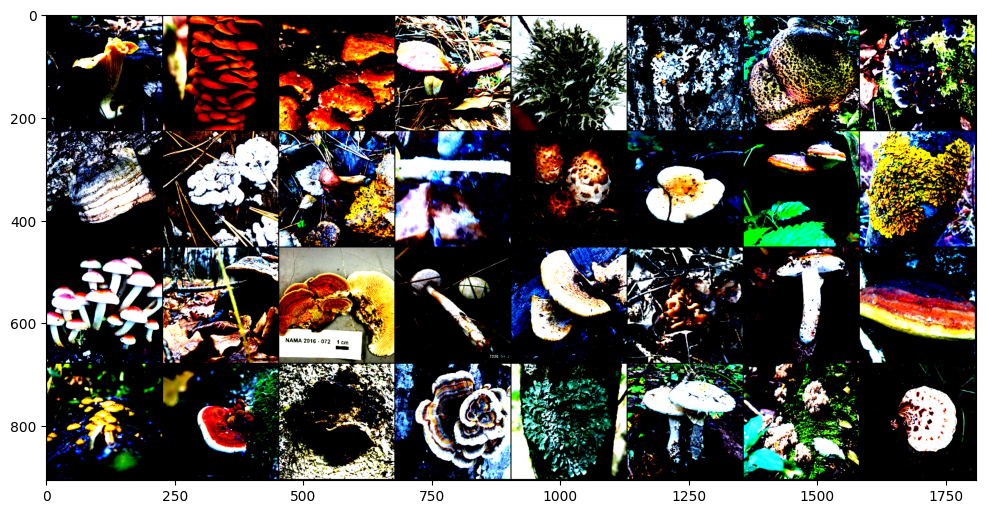

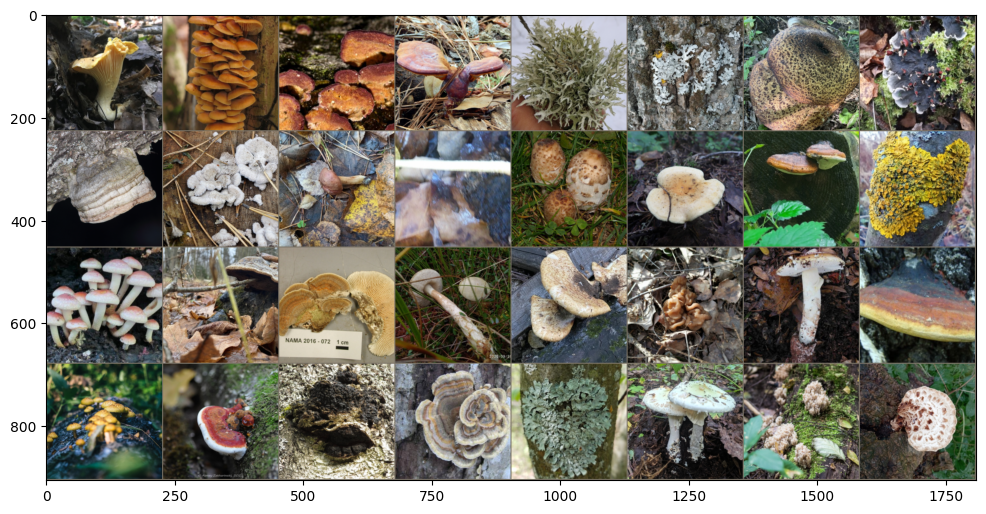

In [13]:
for images, labels in datamodule.test_dataloader():
    break
im=make_grid(images,nrow=8)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                   std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [14]:
device = torch.device("cpu")   #"cuda:0"

model.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in datamodule.test_dataloader():
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

print(classification_report(y_true,y_pred,target_names=class_names,digits=4))

                             precision    recall  f1-score   support

          Agaricus augustus     0.3529    0.5455    0.4286        11
      Agaricus xanthodermus     0.2353    0.5333    0.3265        15
     Amanita amerirubescens     0.1786    0.3846    0.2439        13
            Amanita augusta     0.6429    0.4500    0.5294        20
        Amanita brunnescens     0.2857    0.2857    0.2857        14
      Amanita calyptroderma     0.4231    0.6471    0.5116        17
            Amanita citrina     0.5000    0.5714    0.5333         7
         Amanita flavoconia     0.3333    0.3077    0.3200        13
           Amanita muscaria     0.9563    0.9459    0.9511       185
         Amanita pantherina     0.7000    0.5833    0.6364        12
          Amanita persicina     0.5000    0.5000    0.5000         2
         Amanita phalloides     0.3529    0.3529    0.3529        17
          Amanita rubescens     0.5000    0.3333    0.4000        12
             Amanita velosa     1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
